# Calibración de la Cámara usando OpenCV

## 0. Resumen
1. Patrón
2. Sacar fotos desde diferentes puntos de vista
3. Encontrar esquinas
4. Ecuaciones de proyección patrón->foto

\begin{equation}
s \begin{bmatrix}
u_i \\ v_i \\ 1
\end{bmatrix} =
\begin{bmatrix}
K
\end{bmatrix}
\begin{bmatrix}
R_k | t_k
\end{bmatrix}
\begin{bmatrix}
X_i \\ Y_i \\ Z_i \\ 1
\end{bmatrix}
\end{equation}

K: 5 (o 4) parámetros

R: 5 (o 9) parámetros

t: 3 parámetros

5. Hallar K, R_k, t_k y de yapa los coeficientes de distorsión.
6. Rectificar la imagen  
7. Bonus: dibujar en 3D  

## 1. Patrón

![](patron.png)



In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print("OpenCV version " + cv2.__version__)
print("Numpy version " + np.__version__)


OpenCV version 4.6.0
Numpy version 1.23.1


In [5]:
import glob

import PIL.ExifTags
import PIL.Image

# Fotos desde distintos puntos de vista

In [44]:
calib_fnames = glob.glob('./imagenes_tp/img_cal_set1/*')

mostrar_figuras = False
idx = 3 

### Identificación de Esquinas, Encontrar Matriz de Cámara

In [ ]:
def table_size():
    # Tamaño del tablero:
    ch_size = (8, 6)

    # lista de todos los puntos que vamos a recolectar
    obj_points = list()
    img_points = list()

    # Lista de los puntos que vamos a reconocer en el mundo
    # objp={(0,0,0), (1,0,0), (2,0,0) .... }
    # corresponden a las coordenadas en el tablero de ajedrez.
    objp = np.zeros((np.prod(ch_size), 3),  dtype=np.float32)
    objp[:, :2] = np.mgrid[0:ch_size[0], 0:ch_size[1]].T.reshape(-1, 2)
    return obj_points, img_points, objp

In [30]:


def calib(calib_fnames):
    obj_points, img_points, objp = table_size()
    
    ## Criterio de corte para el proceso iterativo de refinamientoi de esquinas.
    # Parar si iteramos maxCount veces o si las esquinas se mueven menos de epsilon
    maxCount = 25
    epsilon = 0.001
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, maxCount, epsilon)
    cb_flags = cv2.CALIB_CB_ADAPTIVE_THRESH  
    # cb_flags = cv2.CALIB_CB_FAST_CHECK

    #%matplotlib qt

    for image_fname in calib_fnames:
        print("Procesando: " + image_fname , end='... ')
        img = cv2.imread(image_fname)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # para subpixel solamente gray
        ret, corners = cv2.findChessboardCorners(img_gray, ch_size, flags=cb_flags)
        if ret:
            print('Encontramos esquinas!')
            obj_points.append(objp)
            print('Buscando esquinas en resolución subpixel', end='... ')
            corners_subp = cv2.cornerSubPix(img_gray, corners, (5, 5), (-1, -1), criteria)
            print('OK!')
            img_points.append(corners_subp)
            cv2.drawChessboardCorners(img, ch_size, corners_subp, ret)
            if mostrar_figuras:
                plt.figure()
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.show()

    return obj_points, img_points, img_gray

In [45]:
obj_points, img_points, img_gray = calib(calib_fnames)

Procesando: ./imagenes_tp/img_cal_set1/img_cal1.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal14.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal15.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal2.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal17.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal16.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal3.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal7.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... 

## 5. Calibración
Listo con la identificación de puntos, ahora a calibrar


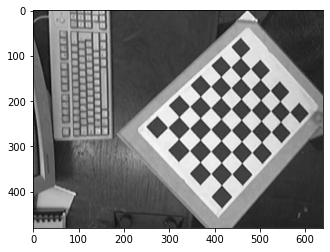

In [46]:
img = cv2.imread(calib_fnames[idx])
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = img_gray.shape

plt.figure()
plt.imshow(img)
plt.show()

In [47]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points,

                                                   (w, h), None, None,flags=cv2.CALIB_ZERO_TANGENT_DIST)

#distCoeffs – Output vector of distortion coefficients
#disotorsion tangencial p1=0,p2=0, puedo hacer cero a k2 y k3
dist[0][1]=0
dist[0][4]=0


print('Camera Matrix = ')
print(mtx)
print('Distortion Coefficients = ')
print(dist)

Camera Matrix = 
[[812.39918072   0.         316.72937723]
 [  0.         812.72585687 247.34172435]
 [  0.           0.           1.        ]]
Distortion Coefficients = 
[[0.02524597 0.         0.         0.         0.        ]]


### SET 1:

Camera Matrix = 
[[812.39918072   0.         316.72937723]
 [  0.         812.72585687 247.34172435]
 [  0.           0.           1.        ]]
Distortion Coefficients = 
[[0.02524597 0.         0.         0.         0.        ]]

### SET 2:

Camera Matrix = 
[[660.98749314   0.         334.47240483]
 [  0.         663.74008116 229.39407095]
 [  0.           0.           1.        ]]
Distortion Coefficients = 
[[0.08694778 0.         0.         0.         0.        ]]

## Conclusion

Ya que el set 1 las distancias focales son mas similares, se toma el set uno para realizar el resto de los analis que comprenden el trabajo.

In [56]:
pd.DataFrame(mtx).to_csv("./save_data/camara_matrix.csv", index=False)
pd.DataFrame(dist).to_csv("./save_data/dist_coefficients.csv", index=False)


# Calibrar Parametros Extrinsecos

In [50]:
calib_fnames_extr = glob.glob('./imagenes_tp/img_bloques/imgCalExtr.png')     

In [52]:
obj_points_extr, img_points_extr, img_gray_extr = calib(calib_fnames_extr)

Procesando: ./imagenes_tp/img_bloques/imgCalExtr.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!


In [54]:
ret_extr, rvecs_extr, tvecs_extr  = cv2.solvePnP(
    obj_points_extr[0],
    img_points_extr[0],
    mtx,
    dist,
    useExtrinsicGuess=False
)

#Converts a rotation matrix to a rotation vector
rotation = cv2.Rodrigues(rvecs_extr)[0]

print('Rotation = ', rotation)
print('Translation = ', tvecs_extr)

Rotation =  [[ 0.99922502 -0.00776181  0.03858902]
 [ 0.00790022  0.99996289 -0.00343565]
 [-0.03856092  0.00373785  0.99924926]]
Translation =  [[-3.9103371]
 [-5.4846594]
 [25.1157339]]


In [55]:
pd.DataFrame(tvecs_extr).to_csv("./save_data/translation_df.csv", index=False)
pd.DataFrame(rotation).to_csv("./save_data/rotation_df.csv", index=False)

# Dibujo de ternas sobre el tablero de ajedres segun los puntos encontrados

In [69]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5) # rojo
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5) # verde
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5) # azul
    cv2.circle(img, (corner[0],corner[1]), 7, (0, 0, 0), -1)
    return img

def calibrar(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img_gray.shape
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points,
                                                   (w, h), None, None)

    return ret, mtx, dist

def rotar(image):
    ancho = image.shape[1] #columnas
    alto = image.shape[0] # filas
    # Rotación
    M = cv2.getRotationMatrix2D((ancho//2,alto//2),180,1)
    img = cv2.warpAffine(image,M,(ancho,alto))
    return img

def get_img(i,nset):
    type_img = 'png' if nset == 1 else 'jpg'
    fname = f'./imagenes_tp/img_cal_set{nset}/img_cal{i}.{type_img}'
    print(fname)
    img = cv2.imread(fname)
    #if nset == 1 and i in range(5,12):
    #    img = rotar(img)
    return img

In [11]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [67]:
def draw_terna(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (8,6),None)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        ret, mtx, dist = calibrar(img)
        ret,rvecs, tvecs = cv2.solvePnP(objp, corners2, mtx, dist)
        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        img = draw(img,corners2,imgpts)

        plt.figure()
        plt.imshow(img)
        plt.show()
    cv2.destroyAllWindows()

./imagenes_tp/img_cal_set1/img_cal1.png


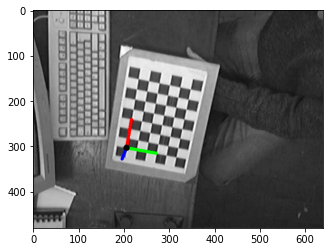

In [70]:
nset = 1
top_range = 2

for i in range (1,top_range):
    if nset == 1 and i in range(5,12):
        continue
    img = get_img(i, nset)
    draw_terna(img)